# Sparse coding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import network
from tqdm import tqdm
import scipy.io as sio
from datetime import datetime

## Load data

In [2]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = sio.loadmat('datasets/IMAGES.mat')
imgs = mat_images['IMAGES']

## Run simulation

In [3]:
np.random.seed(0)

# Simulation constants
H, W, num_images = imgs.shape
num_iter = 500 # number of iterations
nt_max = 1000 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 8 # image patch size
num_units = 100 # number of neurons (units)

eps = 1e-2 # small value which determines convergence
error_list = [] # List to save errors

# Define model
model = network.OlshausenField1996Model(num_inputs=sz**2, num_units=num_units,
                                        batch_size=batch_size,
                                        lr_r=1e-2, lr_Phi=5e-2, lmda=0.4)

# Run simulation
for iter_ in tqdm(range(num_iter)):
    # Get the coordinates of the upper left corner of clopping image randomly.
    beginx = np.random.randint(0, W-sz, batch_size)
    beginy = np.random.randint(0, H-sz, batch_size)

    inputs_list = []

    # Get images randomly
    for i in range(batch_size):        
        idx = np.random.randint(0, num_images)
        img = imgs[:, :, idx]
        clop = img[beginy[i]:beginy[i]+sz, beginx[i]:beginx[i]+sz].flatten()
        inputs_list.append(clop - np.mean(clop))
        
    inputs = np.array(inputs_list) # Input image patches
    
    model.initialize_states() # Reset states
    model.normalize_rows() # Normalize weights
    
    # Input an image patch until latent variables are converged 
    r_tm1 = model.r # set previous r (t minus 1)

    for t in range(nt_max):
        # Update r without update weights 
        error, r = model(inputs, training=False)
        dr = r - r_tm1 

        # Compute norm of r
        dr_norm = np.linalg.norm(dr, ord=2) / (eps + np.linalg.norm(r_tm1, ord=2))
        r_tm1 = r # update r_tm1
        
        # Check convergence of r, then update weights
        if dr_norm < eps:
            error, r = model(inputs, training=True)
            break
        
        # If failure to convergence, break and print error
        if t >= nt_max-2: 
            print("Error at patch:", iter_)
            print(dr_norm)
            break
   
    error_list.append(model.calculate_total_error(error)) # Append errors

    # Print moving average error
    if iter_ % 100 == 99:  
        print("\n iter: "+str(iter_+1)+"/"+str(num_iter)+", Moving error:",
              np.mean(error_list[iter_-99:iter_]))

 20%|██        | 100/500 [00:42<02:56,  2.27it/s]


 iter: 100/500, Moving error: 0.03591115224668925


 40%|████      | 200/500 [01:47<07:29,  1.50s/it]


 iter: 200/500, Moving error: 0.03387167640346698


 60%|██████    | 300/500 [02:47<01:16,  2.60it/s]


 iter: 300/500, Moving error: 0.03381253008819516


 80%|████████  | 400/500 [03:30<00:55,  1.80it/s]


 iter: 400/500, Moving error: 0.03340614715655774


100%|██████████| 500/500 [04:13<00:00,  1.97it/s]


 iter: 500/500, Moving error: 0.03349312413393345


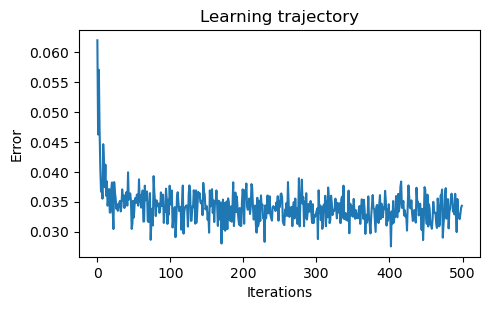

100%|██████████| 100/100 [00:00<00:00, 148.99it/s]


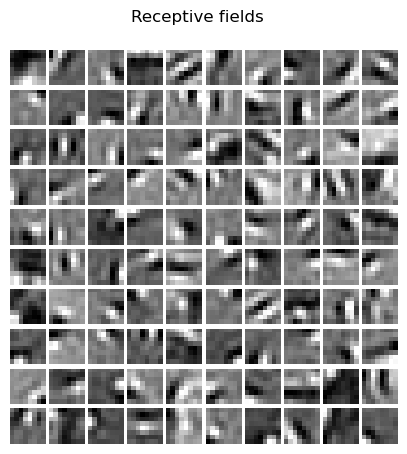

In [8]:
# Plot learning trajectory
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), np.array(error_list))
plt.tight_layout()
plt.title("Learning trajectory")
plt.show()

# Plot Receptive fields
fig = plt.figure(figsize=(5, 5))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(num_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields")
plt.subplots_adjust(top=0.9)
plt.show()

In [31]:
# Plot image reconstruction and associated activity
# Do image reconstruction
batch_size = 5
model.batch_size = batch_size
eps = 1e-8

beginx = np.random.randint(0, W-sz, batch_size)
beginy = np.random.randint(0, H-sz, batch_size)

inputs_list = []

# Get images randomly
for i in range(batch_size):        
    idx = np.random.randint(0, num_images)
    img = imgs[:, :, idx]
    clop = img[beginy[i]:beginy[i]+sz, beginx[i]:beginx[i]+sz].flatten()
    inputs_list.append(clop - np.mean(clop))
    
inputs = np.array(inputs_list) # Input image patches

model.batch_size = batch_size
model.initialize_states() # Reset states
model.normalize_rows() # Normalize weights

# Input an image patch until latent variables are converged 
r_tm1 = model.r # set previous r (t minus 1)

for t in range(nt_max):
    # Update r without update weights 
    error, r = model(inputs, training=False)
    dr = r - r_tm1 

    # Compute norm of r
    dr_norm = np.linalg.norm(dr, ord=2) / (eps + np.linalg.norm(r_tm1, ord=2))
    r_tm1 = r # update r_tm1
    
    # Check convergence of r, then update weights
    if dr_norm < eps:
        print("Iteration reached:", t)
        break
    
    # If failure to convergence, break and print error
    if t >= nt_max-2: 
        print("Error at patch:", iter_)
        print(dr_norm)
        break


Iteration reached: 47


Average image reconstruction error: 0.03292169402376615


100%|██████████| 5/5 [00:00<00:00, 54.52it/s]


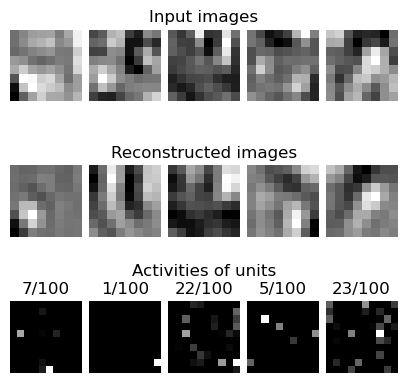

In [51]:
print("Average image reconstruction error:", model.calculate_total_error(error))

recons = model.r @ model.Phi.T

fig = plt.figure(figsize=(5, 5))
for i in tqdm(range(batch_size)):
    plt.subplot(3, 5, i+1)
    plt.imshow(np.reshape(inputs[i, :], (sz, sz)), cmap="gray")
    plt.axis("off")
    
    plt.subplot(3, 5, i+6)
    plt.imshow(np.reshape(recons[i, :], (sz, sz)), cmap="gray")
    plt.axis("off")

    plt.subplot(3, 5, i+11)
    plt.imshow(np.reshape(model.r[i,:], (10, 10)), cmap="gray")
    plt.axis("off")
    plt.title("%i/%i" % (np.count_nonzero(model.r[i,:]), 100))
plt.subplot(3, 5, 3)
plt.title("Input images")
plt.subplot(3, 5, 8)
plt.title("Reconstructed images")
plt.subplot(3, 5, 13)
plt.title("Activities of units\n%i/%i" % (np.count_nonzero(model.r[2,:]), 100))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.subplots_adjust(top=0.9)
plt.show()